In [ ]:
!pip install jupyterthemes
import gzip
import os
from os.path import isfile, join
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(grid=False)

In [2]:
uploaded = files.upload()

Saving t10k-images.idx3-ubyte to t10k-images.idx3-ubyte
Saving t10k-labels.idx1-ubyte to t10k-labels.idx1-ubyte
Saving train-images.idx3-ubyte to train-images.idx3-ubyte
Saving train-labels.idx1-ubyte to train-labels.idx1-ubyte


In [3]:
def list_file(path_data):
   return [join(path_data, i) for i in os.listdir(path_data) if isfile(join(path_data, i))]

In [4]:
def get_images(path_data):
    for f in list_file(path_data):
        if 'train-images' in f:
            with open(f, 'rb') as data:
                _ = int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big') #No se te olvide wey que se va recprriendo el apuntador de 4 en 4
                cols = int.from_bytes(data.read(4), 'big')
                train_images = data.read()
                x_train = np.frombuffer(train_images, dtype=np.uint8)
                x_train = x_train.reshape((num_images, rows, cols))
        elif 'train-labels' in f:
            with open(f, 'rb') as data:
                train_labels = data.read()[8:]
                y_train = np.frombuffer(train_labels, dtype=np.uint8)
        if 't10k-images' in f:
            with open(f, 'rb') as data:
                _ = int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                test_images = data.read()
                x_test = np.frombuffer(test_images, dtype=np.uint8)
                x_test = x_test.reshape((num_images, rows, cols))
        elif 't10k-labels' in f:
            with open(f, 'rb') as data:
                test_labels = data.read()[8:]
                y_test = np.frombuffer(test_labels, dtype=np.uint8)

    return x_train, y_train, x_test, y_test

In [5]:
ruta_directorio = "/content/"
x_train_1, y_train_1, x_test_1, y_test_1 = get_images(ruta_directorio)

In [6]:
x_train_1.shape

(60000, 28, 28)

In [7]:
x_train=x_train_1[:50000].reshape(50000,-1).astype(np.float32)/255 #Debe de tener dimensiones de (50000, 784)
y_train=y_train_1[:50000].reshape(50000,1) #Debe de tener dimensiones de (50000, 1)

x_val=x_train_1[50000:].reshape(10000,-1).astype(np.float32)/255 #Estas madres igual sus respectivas dimensiones
y_val=y_train_1[50000:].reshape(10000,1)

x_test=x_train_1[50000:].reshape(10000,-1).astype(np.float32)/255  #Estas madres tambien
y_test=y_train_1[50000:].reshape(10000,1)

In [8]:
x_val.shape

(10000, 784)

In [9]:
def plt_num(imagen):
  plt.imshow(imagen.squeeze(), cmap=plt.get_cmap("gray"))
  plt.axis("off")
  plt.show

La imagen contien es numero: 3


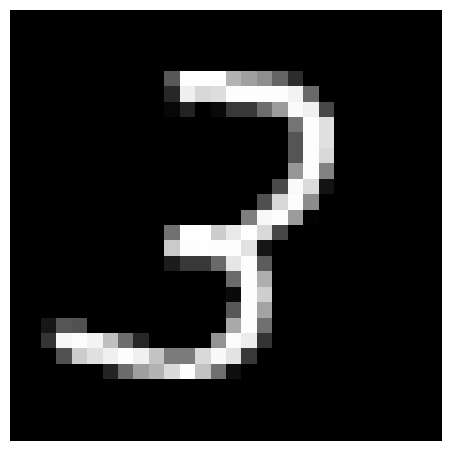

In [10]:
num_ima=np.random.randint(len(y_test))
print("La imagen contien es numero:"+" "+str(y_test_1[num_ima]))
plt_num(x_test_1[num_ima])

##Recuerda el modelo de las redes: z sale de las neuronas, aplicamos la función de activación, este paso se repite dependiendo de las capas internas, despues aplicamos la funcion de "probabilidad normalizadora" y por ultimo aplicamos y minimizamos la funcion de perdida.


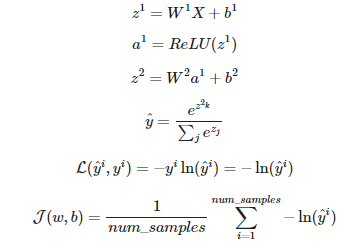



##Cada imagen que entra en las neuronas receptoras tendra que ser convertida a un vector con 784 elementos.

In [11]:
def miniconjuntos(size, x, y, shuffle = True): #Cremos pequeños conjuntos porque esta cabron meter 50000 de golpe
    assert x.shape[0] == y.shape[0], "Algo esta mal we"
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]

    return ((x[i:i+size], y[i:i+size]) for i in range(0, total_data, size))

In [12]:
def ini_param(Entrada, neuronas): #Entrada será el numero de neuronas de entrada, y neuronas una lista del numero de neuronas
# de cada capa en este caso [200, 10] en la primera capa 200 neuronas y en la segunda capa 10 neuronas
#iniciamos los parámetros de los coeficientes de cada conexión de sinapsis y el bais de salida. Al ser dos capas ocupamos dos matrices de coeficientes de sinapsis.
  w_1=np.random.randn(neuronas[0], Entrada) * 0.001
  b_1=np.zeros((neuronas[0], 1))

  w_2=np.random.randn(neuronas[1], neuronas[0]) * 0.001
  b_2=np.zeros((neuronas[1], 1))
  return {'W1': w_1, 'b1':b_1, 'W2':w_2, 'b2':b_2}


In [92]:
def Relu(x): #Función de activación
  return np.maximum(0,x)

def scores(x, parametros, f_activacion): # Modelo lineal de salida de cada neurona

  z_1= parametros["W1"] @ x + parametros["b1"]
  a_1 =f_activacion(z_1)
  z_2= parametros["W2"] @ a_1 + parametros["b2"]

  return z_2, z_1, a_1

def sofmax(x): #Función de probabilidad y normalización
  proba=np.exp(x)/np.sum(np.exp(x), axis =0)
  return proba

In [93]:
parametros=ini_param(28*28, [200,10])
parametros["W2"].shape

(10, 200)

In [95]:
z_2, z_1, a_1=scores(x_train[:64].T, parametros, Relu)

In [96]:
def x_entropy(score, y, batch_size=64): #juntamos la función sofmax y calculamos la función de perdida para minimizarla y asi poder modificar nuestros coeficientes
  proba=sofmax(score) # de sinapsis y el bais
  y_hat=proba[y.squeeze(), np.arange(batch_size)]
  costo= np.sum(-np.log(y_hat))/batch_size
  return proba, costo

In [104]:
def backward(probs, x, y, z1, a1, parameters, batch_size=64): #Minimizamos la funcion de costos, pero para obtener nuevos coeficientes tenemos que retropropagar el
    grads = {} # gradiente y usamos una regla de la cadena para cada coeficiente que queremos minimizar
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # y-hat - y
    dz2 = probs.copy()

    dW2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis =1, keepdims=True) / batch_size
    da1 = parameters['W2'].T @ dz2

    dz1 = da1.copy()
    dz1[z1 <= 0 ] =0

    dW1 = dz1 @ x
    db1 = np.sum(dz1, axis=1, keepdims=True)

    assert parameters['W1'].shape == dW1.shape, 'W1 no igual forma'
    assert parameters['W2'].shape == dW2.shape, 'W2 no igual forma'
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'

    grads = {'w1':dW1,  'b1':db1, 'W2':dW2, 'b2':db2} #Son los valores del gradiente en cada variable en el diccionario

    return grads

In [98]:
y_hat, cost =x_entropy(z_2, y_train[:64])

In [99]:
y_hat.shape

(10, 64)

In [100]:
grads = backward(y_hat, x_train[:64], y_train[:64], z_1, a_1, parametros)

In [107]:
def accuracy(x_data, y_data , mb_size=64):
  Correct=0
  total=0
  for i, (x,y) in enumerate(miniconjuntos(mb_size, x_data, y_data)):
      z_2, z_1, a_1=scores(x.T, parametros, Relu)
      y_hat, cost =x_entropy(z_2, y, batch_size=len(x))

      Correct += np.sum(np.argmax(y_hat, axis=0)==y.squeeze())
      total += y_hat.shape[1]

  return Correct/total

In [108]:
def train(epochs, parameters, mb_size=64, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(miniconjuntos(mb_size, x_train, y_train)):
            z_2, z1, a1 = scores(x.T, parametros=parametros, f_activacion=Relu)
            y_hat, cost = x_entropy(z_2, y, batch_size=len(x))
            grads = backward(y_hat, x, y, z1, a1, parameters, batch_size=len(x))

            parameters['W1'] = parameters['W1'] - learning_rate*grads['w1']
            parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
            parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
            parameters['W2'] = parameters['W2'] - learning_rate*grads['W2']

        print(f'costo es: {cost}, y accuracy: {accuracy(x_val, y_val, mb_size)}')
    return parameters


In [174]:
mb_size = 512
learning_rate = 1e-3
epochs = 50
parameters = train(epochs=epochs, parameters=parametros, mb_size=mb_size, learning_rate=learning_rate)

costo es: 0.06414881119428197, y accuracy: 0.9639
costo es: 0.1386578144272183, y accuracy: 0.9641
costo es: 0.1099759818020532, y accuracy: 0.9632
costo es: 0.1129755530387969, y accuracy: 0.9635
costo es: 0.05629973628778335, y accuracy: 0.9638
costo es: 0.061331823578256985, y accuracy: 0.9636
costo es: 0.0723742863569952, y accuracy: 0.9639
costo es: 0.0692075283255131, y accuracy: 0.9638
costo es: 0.061757374466892875, y accuracy: 0.9639
costo es: 0.10369852296533986, y accuracy: 0.9636
costo es: 0.05103828190193876, y accuracy: 0.9635
costo es: 0.112280020514914, y accuracy: 0.9636
costo es: 0.03630424692637865, y accuracy: 0.9639
costo es: 0.08152410911333709, y accuracy: 0.9638
costo es: 0.07661848617217729, y accuracy: 0.9636
costo es: 0.08250592116035559, y accuracy: 0.9636
costo es: 0.07903659293539349, y accuracy: 0.9639
costo es: 0.07414342359365463, y accuracy: 0.964
costo es: 0.03396799757497279, y accuracy: 0.9635
costo es: 0.08703467478711155, y accuracy: 0.9633
costo 

In [175]:
accuracy(x_train, y_train, mb_size)

0.97842

In [176]:
accuracy(x_test, y_test, mb_size)

0.9631

In [177]:
def predict(x):
    scores2, _, _ = scores(x, parametros, Relu)
    return np.argmax(scores2)

In [178]:
x_test[0].reshape(-1, 1).shape

(784, 1)

el valor predicho es: 1


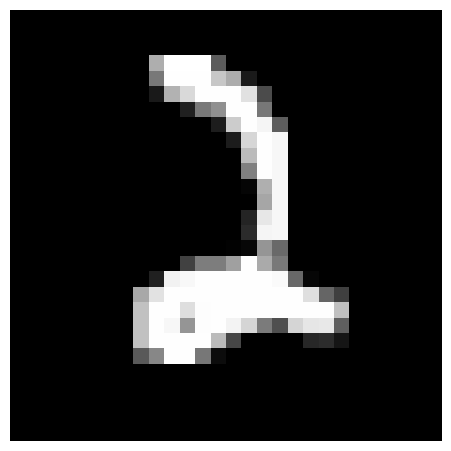

In [182]:
idx = np.random.randint(len(y_test))
plt_num(x_test_1[idx])
pred = predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}')